# FGSM
[Ian J. Goodfellow et al. in “Explaining and Harnessing Adversarial Examples,” (2015)](https://arxiv.org/abs/1412.6572).

# 1. 事前準備と確認

## 必要なライブラリのインポート

In [1]:
from imagenet_util import *

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical

## ResNet50 を生成

In [2]:
model = ResNet50(weights='imagenet')

Run the test images through it.

## オリジナル画像のロードと表示

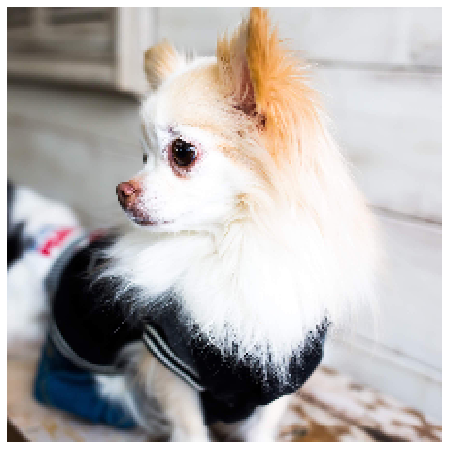

In [3]:
original_image_path = '../../images/chihuahua1.jpg'
original_image = load_img(original_image_path, target_size=(224, 224))
original_image = img_to_array(original_image)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(original_image/255.0)

## オリジナル画像の正規化

In [4]:
norm_original_image = preprocess_input(original_image.copy())

## オリジナル画像の推論と分類

In [5]:
Y_hat = model.predict(np.expand_dims(norm_original_image, 0)) # 推論
_, original_name, original_score = get_top_pred(Y_hat) # 分類

# 分類結果とスコアを表示
print('Prediction: {0} - score {1:.2f}%'.format(original_name, original_score * 100))

Prediction: Chihuahua - score 83.65%


## 正解データ（One-Hot）の生成

In [6]:
Y = to_categorical([151], num_classes=1000) # 151 は Chihuahua クラスのインデックス
print(Y.shape)

(1, 1000)


# 2. FGSM クラス開発と勾配の符号の計算

## FGSM クラス

In [7]:
class FGSM:
    """ FGSM
    Attributes:
        classifier (Model) : モデル
        loss : 損失関数
    """

    def __init__(self, classifier, loss = tf.keras.losses.CategoricalCrossentropy()):

        # 引数をインスタンス変数にセット
        self.classifier = classifier
        self.loss = loss

    def signed_gradient(self, norm_original_image, Y):
        """
        勾配の符号を計算し、返す
        Args:
            norm_original_image (ndarray): 正規化されたオリジナル画像 `(224, 224, 3)`
            Y (ndarray): 正解データ `(1, 1000)`
        Returns:
            signed_gradient (ndarray): 勾配の符号 `(224, 224, 3)`
        """
        
        # 正規化されたオリジナル画像のバッチ化 `(1, 224, 224, 3)`
        X = np.expand_dims(norm_original_image, 0)
        
        # Tensor にキャスト
        X = tf.cast(X, tf.float32) 

        # 勾配を計算
        with tf.GradientTape() as tape:
            tape.watch(X)
            Y_hat = self.classifier(X) # 推論
            loss = self.loss(Y, Y_hat) # 誤差
        gradients = tape.gradient(loss,  X) # 「正規化されたオリジナル画像」についての誤差の勾配 `(1, 224, 224, 3)`
        
        # バッチデータである gradients から1件目のデータを取得 `(224, 224, 3)`
        gradient = gradients[0]
        
        # 勾配に sign 関数を適用し、勾配の符号を得る
        signed_gradient = tf.sign(gradient)
        
        # ndarray に変換
        signed_gradient = signed_gradient.numpy()

        # signed_gradient を返す
        return signed_gradient

## 勾配の符号を取得

In [8]:
attack = FGSM(model)
signed_gradient = attack.signed_gradient(norm_original_image, Y)

# 3. 勾配とは逆の方向にオリジナル画像を移動させる実験

## 複数の epsilon で逆敵対的サンプルを生成

In [9]:
# 逆敵対的サンプルを格納するリスト
norm_rev_adv_image_list = []

# 3つの epsilon を準備
epsilons = np.array([0.0001, 0.001, 0.1]) * 255

# epsilon ごとに逆敵対的サンプルを生成し、 norm_rev_adv_image_list に格納
for epsilon in epsilons:

    # 勾配の符号と epsilon の積
    perturbation = epsilon * signed_gradient
    
    # 正規化されたオリジナル画像からノイズを引いて、逆敵対的サンプルを生成
    norm_rev_adv_image = norm_original_image - perturbation
    
    # クリッピング
    norm_rev_adv_image = clip_imagenet(norm_rev_adv_image)
    
    # 逆敵対的サンプルを norm_rev_adv_image_list に格納
    norm_rev_adv_image_list.append(norm_rev_adv_image)

## オリジナル画像と逆敵対的サンプルの表示

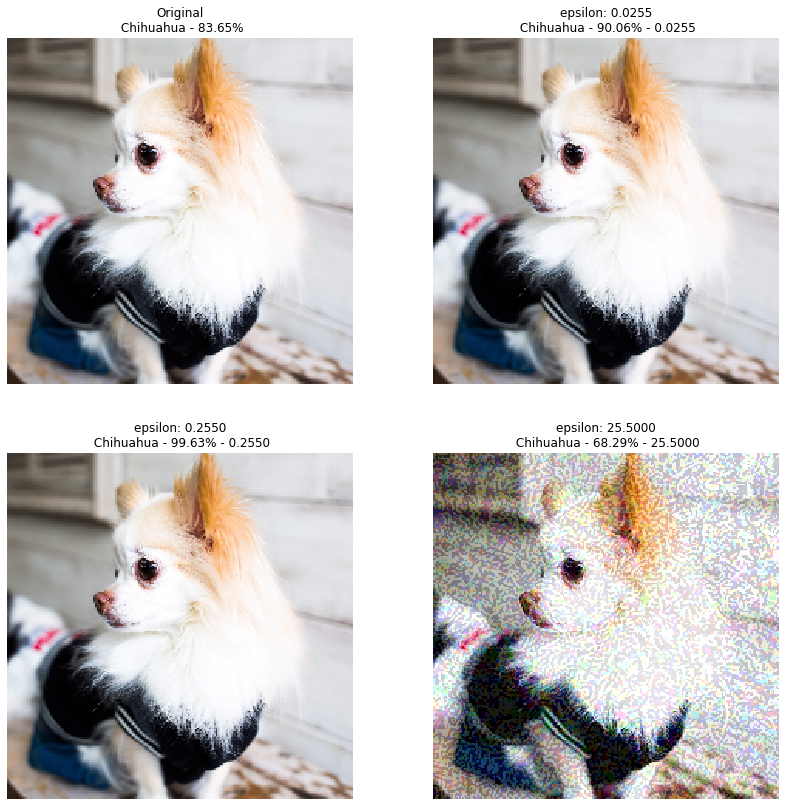

In [10]:
plt.figure(figsize=(14, 14))

# オリジナル画像を表示
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('Original\n {0} - {1:.2f}%'.format(original_name, original_score * 100))
plt.imshow(original_image/255.0)

# 逆敵対的サンプルを epsilon ごとに表示
for i in range(len(norm_rev_adv_image_list)):
    
    # リストから正規化された逆敵対的サンプル norm_rev_adv_image を取得
    norm_rev_adv_image = norm_rev_adv_image_list[i]
    
    # norm_rev_adv_image の推論と分類
    Y_hat_adv = model.predict(np.expand_dims(norm_rev_adv_image, 0))
    _, rev_adv_name, rev_adv_score = get_top_pred(Y_hat_adv)
    
    # norm_rev_adv_image の非正規化
    rev_adv_image = postprocess_imagenet(norm_rev_adv_image)
    
    # Linf を計算
    Linf = np.linalg.norm((rev_adv_image - original_image).reshape(-1), ord=np.inf)
    
    # 逆敵対的サンプルを表示
    plt.subplot(2, 2, i+2)
    plt.axis('off')
    plt.title('epsilon: {0:.4f}\n {1} - {2:.2f}% - {3:.4f}'.format(epsilons[i],  rev_adv_name, rev_adv_score * 100, Linf))
    plt.imshow(rev_adv_image/255.0)

# 4. 敵対的サンプルの生成と攻撃

## 複数の epsilon で敵対的サンプルを生成

In [11]:
# 敵対的サンプルを格納するリスト
norm_adv_image_list = []

# epsilon ごとに敵対的サンプルを生成し、 norm_adv_image_list に格納
for epsilon in epsilons:

    # 勾配の符号と epsilon の積
    perturbation = epsilon * signed_gradient

    # 正規化されたオリジナル画像にノイズを足して、敵対的サンプルを生成
    norm_adv_image = norm_original_image + perturbation

    # クリッピング
    norm_adv_image = clip_imagenet(norm_adv_image)

    # 敵対的サンプルを norm_adv_image_list に格納
    norm_adv_image_list.append(norm_adv_image)

## オリジナル画像と敵対的サンプルの表示

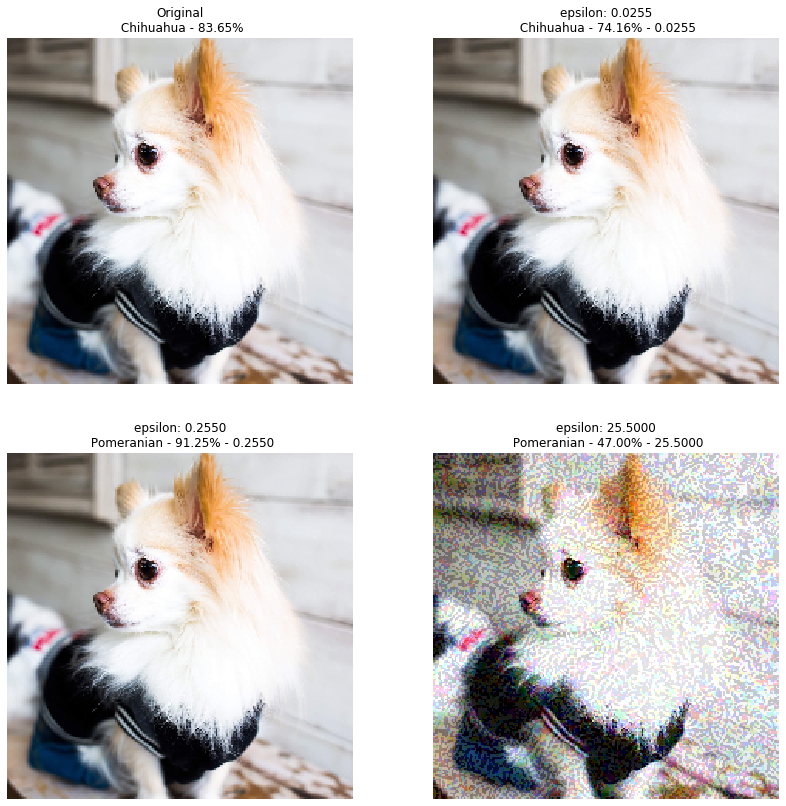

In [12]:
plt.figure(figsize=(14, 14))

# オリジナル画像を表示
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('Original\n {0} - {1:.2f}%'.format(original_name, original_score * 100))
plt.imshow(original_image/255.0)

# 敵対的サンプルを epsilon ごとに表示
for i in range(len(norm_adv_image_list)):
    # リストから正規化された敵対的サンプル norm_adv_image を取得
    norm_adv_image = norm_adv_image_list[i]
    
    # norm_adv_image の推論と分類
    Y_hat_adv = model.predict(np.expand_dims(norm_adv_image, 0))
    _, adv_name, adv_score = get_top_pred(Y_hat_adv)
    
    # norm_adv_image の非正規化
    adv_image = postprocess_imagenet(norm_adv_image)
    
    # Linf を計算
    Linf = np.linalg.norm((adv_image - original_image).reshape(-1), ord=np.inf)
    
    # 敵対的サンプルを表示
    plt.subplot(2, 2, i+2)
    plt.axis('off')
    plt.title('epsilon: {0:.4f}\n {1} - {2:.2f}% - {3:.4f}'.format(epsilons[i],  adv_name, adv_score * 100, Linf))
    plt.imshow(adv_image/255.0)